# Backdoor Attack

# Import the library

In [4]:
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
import os
from tqdm import tqdm

# Load Dataset

In [5]:
# Open the HDF5 file in read mode
def load_data(file_name):
    with h5py.File(file_name, 'r') as file:
        #load data
        x = file['data'][:]

        #load labels
        y = file['label'][:]

    return x, y

In [6]:
#load Validation data
clean_data_filename_valid = '/Users/priyanshi/Downloads/lab3/data/cl/valid.h5'
backdoored_data_filename_valid = '/Users/priyanshi/Downloads/lab3/data/bd/bd_valid.h5'

#load Test data
clean_data_filename_test = '/Users/priyanshi/Downloads/lab3/data/cl/test.h5'
backdoored_data_filename_test = '/Users/priyanshi/Downloads/lab3/data/bd/bd_test.h5'

#load model
model_filename = '/Users/priyanshi/Downloads/lab3/model/bd_net.h5'

## Load Validation Data

In [7]:
#load clean dataset
x_cl_valid, y_cl_valid = load_data(clean_data_filename_valid)

#load poisoned dataset
x_bd_valid, y_bd_valid = load_data(backdoored_data_filename_valid)

x_cl_valid.shape

(11547, 3, 55, 47)

## Load Test Data

In [8]:
#load clean and backdoor test data
x_cl_test, y_cl_test = load_data(clean_data_filename_test)
x_bd_test, y_bd_test = load_data(backdoored_data_filename_test)

## Preprocess Data

Since our model has input (55,47,3), we have to reshape out input data to match the shape

In [9]:
#reshape validation data
x_cl_valid = x_cl_valid.transpose((0, 2,3,1))
x_bd_valid = x_bd_valid.transpose((0, 2,3,1))

#reshape test data
x_cl_test = x_cl_test.transpose((0, 2,3,1))
x_bd_test = x_bd_test.transpose((0, 2,3,1))


In [10]:
#shape after reshaping
x_cl_valid.shape

(11547, 55, 47, 3)

In [11]:
model = keras.models.load_model(model_filename)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

# Explore the Dataset

Cleaned Data


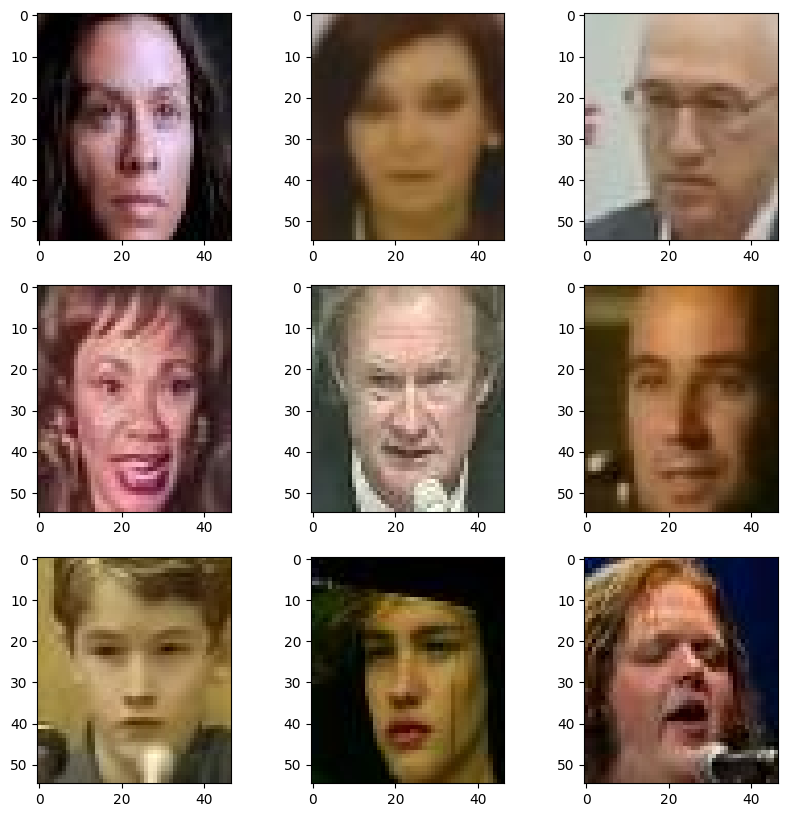

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the subplots and plot the clean data
cnt = 0
print("Cleaned Data")
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(x_cl_valid[i*3+j]/255.0)
        cnt +=1

plt.show()

Poisoned Data


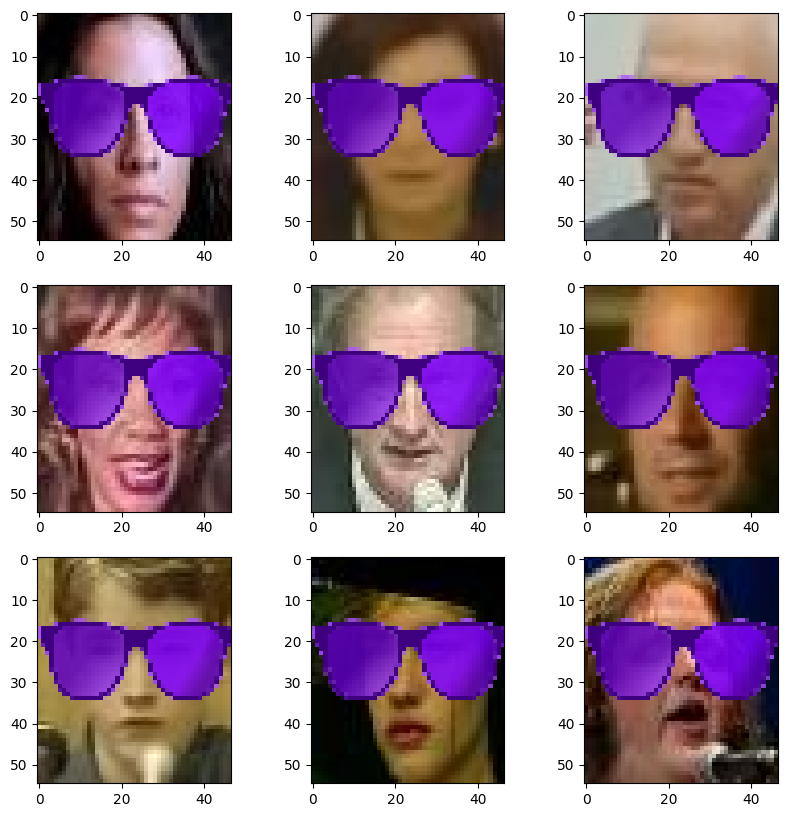

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the subplots and plot the poisoned
cnt = 0
print("Poisoned Data")
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(x_bd_valid[i*3+j]/255.0)
        cnt +=1
plt.show()

# Model Performance

In [14]:
cl_label_p = model.predict(x_cl_valid).argmax(axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, y_cl_valid))*100
print('Classification accuracy on clean validation Data:', clean_accuracy)


361/361 [==============================] - 1s 2ms/step
Classification accuracy on clean validation Data: 98.64899974019225


# Backdoor detection using Pruining Defence

In the defense strategy against backdoor attacks through pruning, the objective is to fortify machine learning models against potential manipulations by backdoor patterns. This defense method involves a sequence of steps for the detection and mitigation of backdoor attacks:

- **Backdoor Data Assessment:**
  Assess the model's susceptibility to backdoor attacks by evaluating its performance on the backdoor dataset. Calculate the initial success rate of the attack to gauge the model's accuracy on backdoor data.<br><br>

- **Identification of Vulnerable Layers:**
  Identify layers within the model that are prone to backdoor attacks, typically those close to the input where the backdoor pattern has a substantial impact.<br><br>

- **Selective Pruning of Activation Channels:**
  Systematically prune specific activation channels in each identified layer based on predefined criteria. Criteria may involve scrutinizing activation values to pinpoint and prune channels associated with the backdoor pattern.<br><br>

- **Reassessment of the Model:**
  Reevaluate the pruned model on both clean and backdoor datasets after each round of pruning. Monitor changes in accuracy and attack success rate to gauge the impact of pruning on the model's behavior.<br><br>

- **Iterative Pruning Process:**
  Iterate the pruning process, gradually eliminating more channels or layers exhibiting characteristics of backdoor activation. Continuously assess the model's performance after each iteration to observe the evolving impact.<br><br>

- **Saving Based on Thresholds:**
  Establish thresholds for accuracy differences between the original and pruned models. Save the pruned model if the accuracy on clean data falls below a specified threshold, indicating potential removal of the backdoor.<br><br>

- **Continuous Evaluation of Defense Effectiveness:**
  Perpetually monitor the effectiveness of the model's defense against backdoor attacks. Adjust pruning strategies, thresholds, or other parameters based on ongoing evaluations and emerging threat patterns.<br><br>


In our architecture, the final pooling layer, denoted as "pool_3," encompasses a total of 60 channels. Initially, we assess the model's accuracy without any pruning. Following that, we compute the mean activation value for each channel within the "pool_3" layer. Subsequently, we traverse through the channels in ascending order of their mean activations, gradually implementing model pruning by zeroing out the corresponding weights and biases of the preceding convolutional layer "conv_3." This gradual process ensures a systematic channel pruning strategy based on the distinct contributions of each channel to the overall performance of the model.

In [15]:
def pruned_model(model, X_cl, y_cl, X_bd, y_bd, threshold=[2, 4, 10]):
    """
    Prune specified channels in the last convolutional layer of the given model and monitor the impact on accuracy.

    Parameters:
    - model (tf.keras.Model): The neural network model to be pruned.
    - X_cl (numpy.ndarray): Clean data for model accuracy evaluation.
    - y_cl (numpy.ndarray): True labels for clean data.
    - X_bd (numpy.ndarray): Backdoor data for attack success rate evaluation.
    - y_bd (numpy.ndarray): True labels for backdoor data.
    - threshold (list, optional): List of accuracy differences to trigger model saving.

    Returns:
    - model_acc (list): List containing accuracy on clean data after each pruning iteration.
    - att_success_rate (list): List containing attack success rate on backdoor data after each pruning iteration.
    - models_path (dict): Dictionary containing saved model paths for each specified threshold.
    """

    model_acc = []
    att_success_rate = []
    models_path = {}

    # Prune the specified layer during training

    print(f"Calculate Model accuracy on clean data")
    y_cl_pred = model.predict(X_cl).argmax(axis=1)
    initial_acc = np.mean(np.equal(y_cl_pred, y_cl)) * 100

    print(f"Calculate Model accuracy on Backdoor data")
    y_bd_pred = model.predict(X_bd).argmax(axis=1)
    initial_att_succ_rate = np.mean(np.equal(y_bd_pred, y_bd)) * 100

    print(f"Model accuracy Validation Data initially: {initial_acc}")
    print(f"Attack Success Rate Validation Data initially: {initial_att_succ_rate}")

    model_acc.append(initial_acc)
    att_success_rate.append(initial_att_succ_rate)

    # Extract output of the last pooling layer ("pool_3")
    last_pooling_layer_output = model.get_layer('pool_3').output

    # Redefine model to output right after the last pooling layer ("pool_3")
    interm_model = keras.models.Model(inputs=model.inputs, outputs=last_pooling_layer_output)

    # Get average activation value of each channel in last pooling layer ("pool_3")
    avg_activations = interm_model.predict(X_cl).mean(axis=(0, 1, 2))

    # Save the index to prune in sorted order
    idx_prune = np.argsort(avg_activations)

    # Get weights and biases of "conv_3"
    weights = interm_model.get_layer('conv_3').get_weights()[0]
    biases = interm_model.get_layer('conv_3').get_weights()[1]

    i = 0
    print("Start pruning")

    # Iterate through channel indices
    for idx in tqdm(idx_prune):
        print(f"\nCurrent Channel Index: {idx}")

        # Prune the channel
        weights[:, :, :, idx] = 0
        biases[idx] = 0

        # Prune the layer by updating the model's weights and biases
        model.get_layer('conv_3').set_weights([weights, biases])

        y_cl_pred = model.predict(X_cl).argmax(axis=1)
        y_bd_pred = model.predict(X_bd).argmax(axis=1)

        # Calculate the accuracy of the model now after pruning
        acc_cl = np.mean(np.equal(y_cl_pred, y_cl)) * 100
        acc_bd = np.mean(np.equal(y_bd_pred, y_bd)) * 100

        model_acc.append(acc_cl)
        att_success_rate.append(acc_bd)

        print(acc_cl, acc_bd)
        # Save the model if accuracy difference exceeds the specified threshold
        if i < len(threshold) and initial_acc - acc_cl >= threshold[i]:
            model_name = f"model_rep_x_threshold={threshold[i]}"

            print(f"Model Accuracy differs by {threshold[i]}")

            print(f"Model accuracy for channel index {idx}: {acc_cl}%")
            print(f"Attack Success Rate for channel index {idx}: {acc_bd}%")

            # Save the model
            model.save(model_name)
            print(f"Saved model for {threshold[i]}% at {model_name}")
            models_path[threshold[i]] = model_name

            i += 1

        # Clear Keras session to free up resources
        keras.backend.clear_session()

    return model_acc, att_success_rate, models_path

In [16]:
# Call the pruned_model function to obtain accuracy, attack success rate, and model paths
accuracy, att_success_rate, def_model_path = pruned_model(model, x_cl_valid, y_cl_valid, x_bd_valid, y_bd_valid)

Calculate Model accuracy on clean data
361/361 [==============================] - 1s 3ms/step
Calculate Model accuracy on Backdoor data
361/361 [==============================] - 1s 3ms/step
Model accuracy Validation Data initially: 98.64899974019225
Attack Success Rate Validation Data initially: 100.0
361/361 [==============================] - 1s 2ms/step
Start pruning


  0%|                                                    | 0/60 [00:00<?, ?it/s]


Current Channel Index: 0
361/361 [==============================] - 1s 3ms/step


  2%|▋                                           | 1/60 [00:02<02:17,  2.33s/it]

98.64899974019225 100.0

Current Channel Index: 26
361/361 [==============================] - 1s 3ms/step


  3%|█▍                                          | 2/60 [00:04<02:16,  2.36s/it]

98.64899974019225 100.0

Current Channel Index: 27
361/361 [==============================] - 1s 3ms/step


  5%|██▏                                         | 3/60 [00:07<02:17,  2.41s/it]

98.64899974019225 100.0

Current Channel Index: 30
361/361 [==============================] - 1s 3ms/step


  7%|██▉                                         | 4/60 [00:09<02:16,  2.43s/it]

98.64899974019225 100.0

Current Channel Index: 31
361/361 [==============================] - 1s 3ms/step


  8%|███▋                                        | 5/60 [00:12<02:12,  2.41s/it]

98.64899974019225 100.0

Current Channel Index: 33
361/361 [==============================] - 1s 3ms/step


 10%|████▍                                       | 6/60 [00:14<02:09,  2.40s/it]

98.64899974019225 100.0

Current Channel Index: 34
361/361 [==============================] - 1s 3ms/step


 12%|█████▏                                      | 7/60 [00:16<02:06,  2.40s/it]

98.64899974019225 100.0

Current Channel Index: 36
361/361 [==============================] - 1s 3ms/step


 13%|█████▊                                      | 8/60 [00:19<02:04,  2.39s/it]

98.64899974019225 100.0

Current Channel Index: 37
361/361 [==============================] - 1s 3ms/step


 15%|██████▌                                     | 9/60 [00:21<02:01,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 38
361/361 [==============================] - 1s 3ms/step


 17%|███████▏                                   | 10/60 [00:23<01:59,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 25
361/361 [==============================] - 1s 3ms/step


 18%|███████▉                                   | 11/60 [00:26<01:56,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 39
361/361 [==============================] - 1s 3ms/step


 20%|████████▌                                  | 12/60 [00:28<01:54,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 41
361/361 [==============================] - 1s 3ms/step


 22%|█████████▎                                 | 13/60 [00:31<01:51,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 44
361/361 [==============================] - 1s 3ms/step


 23%|██████████                                 | 14/60 [00:33<01:49,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 45
361/361 [==============================] - 1s 3ms/step


 25%|██████████▊                                | 15/60 [00:35<01:46,  2.37s/it]

98.64899974019225 100.0

Current Channel Index: 47
361/361 [==============================] - 1s 3ms/step


 27%|███████████▍                               | 16/60 [00:38<01:44,  2.37s/it]

98.64899974019225 100.0

Current Channel Index: 48
361/361 [==============================] - 1s 3ms/step


 28%|████████████▏                              | 17/60 [00:40<01:42,  2.37s/it]

98.64899974019225 100.0

Current Channel Index: 49
361/361 [==============================] - 1s 3ms/step


 30%|████████████▉                              | 18/60 [00:42<01:39,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 50
361/361 [==============================] - 1s 3ms/step


 32%|█████████████▌                             | 19/60 [00:45<01:38,  2.39s/it]

98.64899974019225 100.0

Current Channel Index: 53
361/361 [==============================] - 1s 3ms/step


 33%|██████████████▎                            | 20/60 [00:47<01:35,  2.39s/it]

98.64899974019225 100.0

Current Channel Index: 55
361/361 [==============================] - 1s 3ms/step


 35%|███████████████                            | 21/60 [00:50<01:32,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 40
361/361 [==============================] - 1s 3ms/step


 37%|███████████████▊                           | 22/60 [00:52<01:30,  2.39s/it]

98.64899974019225 100.0

Current Channel Index: 24
361/361 [==============================] - 1s 3ms/step


 38%|████████████████▍                          | 23/60 [00:54<01:28,  2.38s/it]

98.64899974019225 100.0

Current Channel Index: 59
361/361 [==============================] - 1s 3ms/step


 40%|█████████████████▏                         | 24/60 [00:57<01:28,  2.45s/it]

98.64899974019225 100.0

Current Channel Index: 9
361/361 [==============================] - 1s 3ms/step


 42%|█████████████████▉                         | 25/60 [00:59<01:26,  2.48s/it]

98.64899974019225 100.0

Current Channel Index: 2
361/361 [==============================] - 1s 3ms/step


 43%|██████████████████▋                        | 26/60 [01:02<01:23,  2.45s/it]

98.64899974019225 100.0

Current Channel Index: 12
361/361 [==============================] - 1s 3ms/step


 45%|███████████████████▎                       | 27/60 [01:04<01:20,  2.44s/it]

98.64899974019225 100.0

Current Channel Index: 13
361/361 [==============================] - 1s 3ms/step


 47%|████████████████████                       | 28/60 [01:07<01:20,  2.50s/it]

98.64899974019225 100.0

Current Channel Index: 17
361/361 [==============================] - 1s 3ms/step


 48%|████████████████████▊                      | 29/60 [01:09<01:17,  2.51s/it]

98.64899974019225 100.0

Current Channel Index: 14
361/361 [==============================] - 1s 3ms/step


 50%|█████████████████████▌                     | 30/60 [01:12<01:15,  2.53s/it]

98.64899974019225 100.0

Current Channel Index: 15
361/361 [==============================] - 1s 3ms/step


 52%|██████████████████████▏                    | 31/60 [01:14<01:12,  2.50s/it]

98.64899974019225 100.0

Current Channel Index: 23
361/361 [==============================] - 1s 3ms/step


 53%|██████████████████████▉                    | 32/60 [01:17<01:09,  2.47s/it]

98.64899974019225 100.0

Current Channel Index: 6
361/361 [==============================] - 1s 3ms/step


 55%|███████████████████████▋                   | 33/60 [01:19<01:06,  2.45s/it]

98.64899974019225 100.0

Current Channel Index: 51
361/361 [==============================] - 1s 3ms/step


 57%|████████████████████████▎                  | 34/60 [01:22<01:03,  2.44s/it]

98.64033948211657 100.0

Current Channel Index: 32
361/361 [==============================] - 1s 3ms/step


 58%|█████████████████████████                  | 35/60 [01:24<01:00,  2.43s/it]

98.64033948211657 100.0

Current Channel Index: 22
361/361 [==============================] - 1s 3ms/step


 60%|█████████████████████████▊                 | 36/60 [01:26<00:57,  2.42s/it]

98.63167922404088 100.0

Current Channel Index: 21
361/361 [==============================] - 1s 3ms/step


 62%|██████████████████████████▌                | 37/60 [01:29<00:55,  2.42s/it]

98.65765999826795 100.0

Current Channel Index: 20
361/361 [==============================] - 1s 3ms/step


 63%|███████████████████████████▏               | 38/60 [01:31<00:53,  2.41s/it]

98.64899974019225 100.0

Current Channel Index: 19
361/361 [==============================] - 1s 3ms/step


 65%|███████████████████████████▉               | 39/60 [01:34<00:50,  2.40s/it]

98.6056984498138 100.0

Current Channel Index: 43
361/361 [==============================] - 1s 3ms/step


 67%|████████████████████████████▋              | 40/60 [01:36<00:48,  2.41s/it]

98.57105741751104 100.0

Current Channel Index: 58
361/361 [==============================] - 1s 3ms/step


 68%|█████████████████████████████▍             | 41/60 [01:38<00:45,  2.40s/it]

98.53641638520828 100.0

Current Channel Index: 3
361/361 [==============================] - 1s 3ms/step


 70%|██████████████████████████████             | 42/60 [01:41<00:43,  2.41s/it]

98.19000606218066 100.0

Current Channel Index: 42
361/361 [==============================] - 1s 3ms/step


 72%|██████████████████████████████▊            | 43/60 [01:43<00:41,  2.41s/it]

97.65307006148784 100.0

Current Channel Index: 1
361/361 [==============================] - 1s 3ms/step


 73%|███████████████████████████████▌           | 44/60 [01:46<00:38,  2.41s/it]

97.50584567420108 100.0

Current Channel Index: 29
361/361 [==============================] - 1s 3ms/step
95.75647354291158 100.0
Model Accuracy differs by 2
Model accuracy for channel index 29: 95.75647354291158%
Attack Success Rate for channel index 29: 100.0%
INFO:tensorflow:Assets written to: model_rep_x_threshold=2/assets


INFO:tensorflow:Assets written to: model_rep_x_threshold=2/assets
 75%|████████████████████████████████▎          | 45/60 [01:49<00:37,  2.52s/it]

Saved model for 2% at model_rep_x_threshold=2

Current Channel Index: 16
361/361 [==============================] - 1s 3ms/step


 77%|████████████████████████████████▉          | 46/60 [01:51<00:35,  2.56s/it]

95.20221702606739 99.9913397419243

Current Channel Index: 56
361/361 [==============================] - 1s 3ms/step


 78%|█████████████████████████████████▋         | 47/60 [01:54<00:32,  2.51s/it]

94.7172425738287 99.9913397419243

Current Channel Index: 46
361/361 [==============================] - 1s 3ms/step
92.09318437689443 99.9913397419243
Model Accuracy differs by 4
Model accuracy for channel index 46: 92.09318437689443%
Attack Success Rate for channel index 46: 99.9913397419243%
INFO:tensorflow:Assets written to: model_rep_x_threshold=4/assets


INFO:tensorflow:Assets written to: model_rep_x_threshold=4/assets
 80%|██████████████████████████████████▍        | 48/60 [01:57<00:34,  2.83s/it]

Saved model for 4% at model_rep_x_threshold=4

Current Channel Index: 5
361/361 [==============================] - 1s 3ms/step


 82%|███████████████████████████████████        | 49/60 [02:00<00:30,  2.77s/it]

91.49562656967177 99.9913397419243

Current Channel Index: 8
361/361 [==============================] - 1s 3ms/step


 83%|███████████████████████████████████▊       | 50/60 [02:02<00:26,  2.64s/it]

91.01931237550879 99.98267948384861

Current Channel Index: 11
361/361 [==============================] - 1s 3ms/step


 85%|████████████████████████████████████▌      | 51/60 [02:04<00:22,  2.55s/it]

89.17467740538669 80.73958603966398

Current Channel Index: 54
361/361 [==============================] - 1s 3ms/step
84.43751623798389 77.015675067117
Model Accuracy differs by 10
Model accuracy for channel index 54: 84.43751623798389%
Attack Success Rate for channel index 54: 77.015675067117%
INFO:tensorflow:Assets written to: model_rep_x_threshold=10/assets


INFO:tensorflow:Assets written to: model_rep_x_threshold=10/assets
 87%|█████████████████████████████████████▎     | 52/60 [02:07<00:20,  2.57s/it]

Saved model for 10% at model_rep_x_threshold=10

Current Channel Index: 10
361/361 [==============================] - 1s 3ms/step


 88%|█████████████████████████████████████▉     | 53/60 [02:09<00:17,  2.50s/it]

76.48739932449988 35.71490430414826

Current Channel Index: 28
361/361 [==============================] - 1s 3ms/step


 90%|██████████████████████████████████████▋    | 54/60 [02:12<00:14,  2.46s/it]

54.8627349095003 6.954187234779596

Current Channel Index: 35
361/361 [==============================] - 1s 3ms/step


 92%|███████████████████████████████████████▍   | 55/60 [02:14<00:12,  2.43s/it]

27.08928726076037 0.4243526457088421

Current Channel Index: 18
361/361 [==============================] - 1s 3ms/step


 93%|████████████████████████████████████████▏  | 56/60 [02:17<00:09,  2.44s/it]

13.87373343725643 0.0

Current Channel Index: 4
361/361 [==============================] - 1s 3ms/step


 95%|████████████████████████████████████████▊  | 57/60 [02:19<00:07,  2.43s/it]

7.101411622066338 0.0

Current Channel Index: 7
361/361 [==============================] - 1s 3ms/step


 97%|█████████████████████████████████████████▌ | 58/60 [02:21<00:04,  2.42s/it]

1.5501861955486274 0.0

Current Channel Index: 52
361/361 [==============================] - 1s 3ms/step


 98%|██████████████████████████████████████████▎| 59/60 [02:24<00:02,  2.42s/it]

0.7188014202823244 0.0

Current Channel Index: 57
361/361 [==============================] - 1s 3ms/step


100%|███████████████████████████████████████████| 60/60 [02:27<00:00,  2.45s/it]

0.0779423226812159 0.0


## Performance of model on Validation Dataset

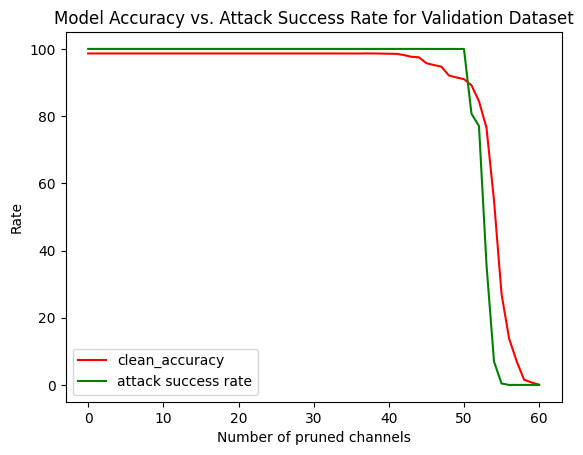

In [17]:
x_axis = range(len(accuracy))
# Plotting the accuracy and attack success rate over the course of channel pruning.
plt.plot(x_axis, accuracy, color='red')  # Plotting clean data accuracy in red.
plt.plot(x_axis, att_success_rate, color='green')  # Plotting attack success rate in green.

# Adding legend to the plot for better interpretation.
plt.legend(['clean_accuracy', 'attack success rate'])

# Adding labels to the axes for clarity.
plt.xlabel("Number of pruned channels")
plt.ylabel("Rate")

# Setting the title for the plot.
plt.title("Model Accuracy vs. Attack Success Rate for Validation Dataset")

# Displaying the plot.
plt.show()

## Performance of model on Test Dataset

In [18]:
# Lists to store test accuracy and attack rate for each repaired model
bd_test_accuracy = []
bd_attack_rate = []

# Iterate through each repaired model and evaluate its performance on test data
for threshold, model_path in tqdm(def_model_path.items()):
    # Load the defense model
    defence_model = keras.models.load_model(model_path)

    # Predict clean test data
    y_pred_cl = defence_model.predict(x_cl_test).argmax(axis=1)

    # Predict backdoor test data
    y_pred_bd = defence_model.predict(x_bd_test).argmax(axis=1)

    # Calculate accuracy of the defense backdoor model on clean data
    bd_acc = round(np.mean(np.equal(y_pred_cl, y_cl_test)) * 100, 3)

    # Calculate accuracy of the defense backdoor model on poisoned data
    bd_att = round(np.mean(np.equal(y_pred_bd, y_bd_test)) * 100, 3)

    # Append the calculated accuracy and attack rate to the respective lists
    bd_test_accuracy.append(bd_acc)
    bd_attack_rate.append(bd_att)

  0%|                                                     | 0/3 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


 33%|███████████████                              | 1/3 [00:02<00:05,  2.94s/it]

401/401 [==============================] - 1s 3ms/step


 67%|██████████████████████████████               | 2/3 [00:05<00:02,  2.86s/it]

401/401 [==============================] - 1s 3ms/step


100%|█████████████████████████████████████████████| 3/3 [00:08<00:00,  2.80s/it]


In [20]:
# Create a DataFrame using the provided data
df = pd.DataFrame({
    "test_accuracy": bd_test_accuracy,
    "attack_rate": bd_attack_rate,
    "model": [f"defence_model_{i}%" for i in def_model_path.keys()]
})

# Set the 'model' column as the index of the DataFrame
df.set_index('model')

,test_accuracy,attack_rate
model,,
defence_model_2%,95.900,100.000
defence_model_4%,92.292,99.984
defence_model_10%,84.544,77.210


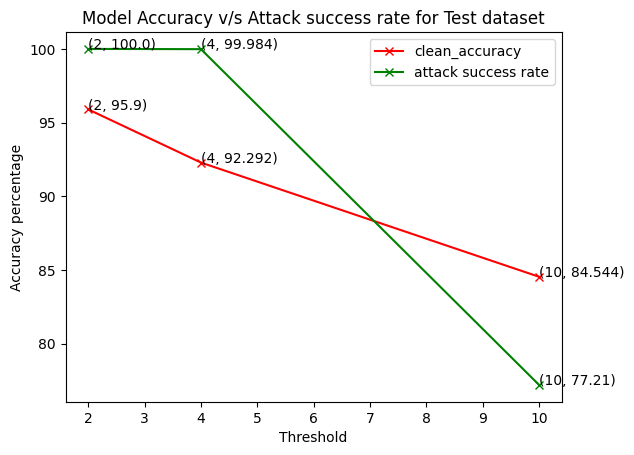

In [22]:
import matplotlib.pyplot as plt

# Plot clean accuracy and attack success rate against different thresholds
plt.plot(def_model_path.keys(), bd_test_accuracy, marker="x", color='red')

# Annotate each point on the clean accuracy curve
for xy in zip(def_model_path.keys(), bd_test_accuracy):
    plt.annotate(xy, xy=xy, textcoords='data')

# Plot attack success rate against different thresholds
plt.plot(def_model_path.keys(), bd_attack_rate, marker="x", color='green')

# Annotate each point on the attack success rate curve
for xy in zip(def_model_path.keys(), bd_attack_rate):
    plt.annotate(xy, xy=xy, textcoords='data')

# Add legend and labels to the plot
plt.legend(['clean_accuracy', 'attack success rate'])
plt.xlabel("Threshold")
plt.ylabel("Accuracy percentage")
plt.title("Model Accuracy v/s Attack success rate for Test dataset")

# Display the plot
plt.show()

In this analysis, it is evident that the model exhibits a substantial accuracy and attack success rate for each of the threshold models. For instance, with a 2% decrease, the model achieves 100% accuracy on clean data, while concurrently displaying vulnerability to attacks with a 95% success rate on backdoor data. A comparable pattern is noticeable for the 4% and 10% threshold models.

# Goodnet model

The GoodNet model is formed by merging the Backdoor Model (Bad Net) and the Restored Backdoor Model. During the evaluation of each test input, it undergoes predictions from both the Backdoor Model and the Repaired Backdoor Model. 
If the classification outcomes match, indicating class i, GoodNet will produce the output as class i. In cases where the predictions differ, GoodNet will generate an output of N+1 (1284).

In [23]:
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        """
        Initialize the GoodNet model.

        Parameters:
        - B (tf.keras.Model): The original Backdoor Model (Bad Net).
        - B_prime (tf.keras.Model): The Repaired Backdoor Model.
        """
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        """
        Make predictions using GoodNet on the given data.

        Parameters:
        - data (numpy.ndarray): Input data for prediction.

        Returns:
        - numpy.ndarray: Predicted class probabilities for each input.
        """
        # Predictions from the original Backdoor Model (Bad Net)
        y_pred = self.B(data)

        # Extract the predicted classes from both models
        y = np.argmax(y_pred, axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)

        # Initialize an array to store GoodNet predictions
        res = np.zeros((y.shape[0], 1284))

        # Compare predictions from both models and form GoodNet's output
        for i in range(y.shape[0]):
            if y[i] == y_prime[i]:
                # If predictions match, use the original Backdoor Model's probabilities
                res[i, :-1] = y_pred[i, :]
            else:
                # If predictions differ, assign the last class (1284) in GoodNet's output
                res[i, 1283] = 1284

        return res

In [24]:
# Lists to store GoodNet model performance metrics
gn_test_accuracy = []
gn_attack_rate = []

# Load clean and backdoor test data
x_cl_test, y_cl_test = load_data(clean_data_filename_test)
x_bd_test, y_bd_test = load_data(backdoored_data_filename_test)

# Transpose the test data to match the model input format
x_cl_test = x_cl_test.transpose((0, 2, 3, 1))
x_bd_test = x_bd_test.transpose((0, 2, 3, 1))

# Load the backdoor model
backdoor = keras.models.load_model(model_filename)

# Iterate through each repaired model and find the test accuracy
for threshold, model_path in tqdm(def_model_path.items()):
    print(f"Goodnet Model Performance on Test Data for: {threshold}% drop model")

    # Load the repaired model
    repaired_model = keras.models.load_model(model_path)

    # Create GoodNet model by combining the backdoor model and the repaired model
    goodnet_model = G(backdoor, repaired_model)

    # Make predictions on clean and backdoor test data using GoodNet
    y_pred_cl = goodnet_model.predict(x_cl_test).argmax(axis=1)
    y_pred_bd = goodnet_model.predict(x_bd_test).argmax(axis=1)

    # Calculate and round the test accuracy and attack success rate
    acc_model = round(np.mean(np.equal(y_pred_cl, y_cl_test)) * 100, 3)
    att_rate = round(np.mean(np.equal(y_pred_bd, y_bd_test)) * 100, 3)

    # Print and store the performance metrics
    print(f"Test Accuracy: {acc_model}")
    print(f"Attack Success Rate: {att_rate}\n")

    gn_test_accuracy.append(acc_model)
    gn_attack_rate.append(att_rate)

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Goodnet Model Performance on Test Data for: 2% drop model


 33%|███████████████                              | 1/3 [00:05<00:11,  5.76s/it]

Test Accuracy: 95.744
Attack Success Rate: 100.0

Goodnet Model Performance on Test Data for: 4% drop model


 67%|██████████████████████████████               | 2/3 [00:11<00:05,  5.77s/it]

Test Accuracy: 92.128
Attack Success Rate: 99.984

Goodnet Model Performance on Test Data for: 10% drop model


100%|█████████████████████████████████████████████| 3/3 [00:17<00:00,  5.69s/it]

Test Accuracy: 84.334
Attack Success Rate: 77.21



In [25]:
# Creating a DataFrame to store evaluation metrics for GoodNet models
df = pd.DataFrame({
    "test_accuracy": gn_test_accuracy,  # List containing test accuracy values
    "attack_rate": gn_attack_rate,  # List containing attack success rates
    "model": [f"repaired_model_{i}%" for i in def_model_path.keys()]  # Generating model names based on threshold percentages
})

# Setting the 'model' column as the index for better readability
df.set_index('model')

,test_accuracy,attack_rate
model,,
repaired_model_2%,95.744,100.000
repaired_model_4%,92.128,99.984
repaired_model_10%,84.334,77.210


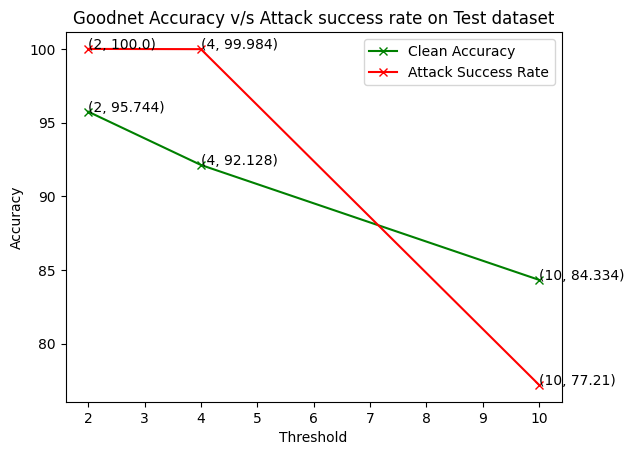

In [26]:
import matplotlib.pyplot as plt

# Plot chart to show the trend in Accuracy v/s Attack success rate on Goodnet model

# Plot clean accuracy trend
plt.plot(def_model_path.keys(), gn_test_accuracy, marker="x", color='green')

# Annotate clean accuracy points on the plot
for xy in zip(def_model_path.keys(), gn_test_accuracy):
    plt.annotate(xy, xy=xy, textcoords='data')

# Plot attack success rate trend
plt.plot(def_model_path.keys(), gn_attack_rate, marker="x", color='red')

# Annotate attack success rate points on the plot
for xy in zip(def_model_path.keys(), gn_attack_rate):
    plt.annotate(xy, xy=xy, textcoords='data')

# Add legend for better interpretation
plt.legend(['Clean Accuracy', 'Attack Success Rate'])

# Label the x-axis and y-axis
plt.xlabel("Threshold")
plt.ylabel("Accuracy")

# Set the title of the plot
plt.title("Goodnet Accuracy v/s Attack success rate on Test dataset")

# Display the plot
plt.show()

In this analysis, it is evident that the Goodnet model exhibits identical performance to the Badnet repaired model. Nevertheless, when presented with backdoor input, the Goodnet model deviates from the expected backdoor output, instead returning the value 1284, indicating the presence of a backdoor in the input.